<a href="https://colab.research.google.com/github/DavidMercadoFaustino/Kaggle/blob/master/Fake_News_Detection/%20Decision_tree_FAKE_NEWS_DETECTION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Importação de bibliotecas para utilização na Leitura e na manipulação de dados
import pandas as pd
import numpy as np
from collections import Counter
import re
import os
import matplotlib.pyplot as plt


In [17]:

for dirname, _, filenames in os.walk('/content/Kaggle'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/Kaggle/test.csv
/content/Kaggle/train.csv
/content/Kaggle/submit.csv


In [72]:
# Carregamento pelo pandas 
df_test = pd.read_csv('/content/Kaggle/test.csv')
df_train = pd.read_csv('/content/Kaggle/train.csv')
df_submit = pd.read_csv('/content/Kaggle/submit.csv')

In [19]:
df_train.tail()

,id,title,author,text,label
20795,20795,Rapper T.I.: Trump a ’Poster Child For White S...,Jerome Hudson,Rapper T. I. unloaded on black celebrities who...,0
20796,20796,"N.F.L. Playoffs: Schedule, Matchups and Odds -...",Benjamin Hoffman,When the Green Bay Packers lost to the Washing...,0
20797,20797,Macy’s Is Said to Receive Takeover Approach by...,Michael J. de la Merced and Rachel Abrams,The Macy’s of today grew from the union of sev...,0
20798,20798,"NATO, Russia To Hold Parallel Exercises In Bal...",Alex Ansary,"NATO, Russia To Hold Parallel Exercises In Bal...",1
20799,20799,What Keeps the F-35 Alive,David Swanson,"David Swanson is an author, activist, journa...",1


# Limpeza dos Dados

In [77]:
#verificarção dos dados faltantes
df_train.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [78]:
#excluir as linhas faltantes no titulo e na corpo do texto
df_train.dropna(subset=['title'], axis=0, inplace=True)

In [79]:
df_train.dropna(subset=['text'], axis=0, inplace=True)

In [80]:
df_test.isnull().sum()

id          0
title     122
author    503
text        7
dtype: int64

In [81]:
df_test.dropna(subset=['title'], axis=0, inplace=True)
df_test.dropna(subset=['text'], axis=0, inplace=True)

In [82]:
print(df_train.isnull().sum())
print(df_test.isnull().sum())

id           0
title        0
author    1918
text         0
label        0
dtype: int64
id          0
title       0
author    496
text        0
dtype: int64


In [41]:
#importação do Natural Toolkits para fazer as limpezas para analises
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [42]:
list_stops_words = stopwords.words("english")
df["title"] = df['title'].str.lower()
df["title"].replace('\n',' ', regex=True, inplace=True)

# Preparação dos dados

In [89]:
# Dividiremos as amostras para Treino e para teste

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_train["title"], df_train["label"], 
                                                    test_size=0.30, 
                                                    random_state=42)

In [90]:
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import PCA

In [112]:
classify = Pipeline(
                [('vect', CountVectorizer(stop_words= list_stops_words,ngram_range=(1,2))), 
                 ('tfidf', TfidfTransformer()),
                 ('clf', DecisionTreeClassifier (max_depth = 2, random_state = 0))])

# Treinamento e Teste do modelo

Nesse primeiro momento vamos analisar primeiramente o modelo de decisão em árvore aplicada para o titulos das matérias.

In [113]:
# treinamento do nosso modelo
classify.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 2), preprocessor=None,
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",...
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                        criterion='gini', max_depth=2,
                                        max_features=None, max_lea

In [107]:
# Importação do metrics para medir o aprendizado da maquina
from sklearn import metrics

In [114]:
# Medição da precisão do modelo utilizando as amostras
classify.score(X_test, y_test)

0.908925919815212

In [115]:
preds = classify.predict(X_test)
print(metrics.classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       1.00      0.82      0.90      3129
           1       0.84      1.00      0.91      2932

    accuracy                           0.91      6061
   macro avg       0.92      0.91      0.91      6061
weighted avg       0.92      0.91      0.91      6061



In [116]:
#fazer um cross validation para validar 
from sklearn.model_selection import cross_val_score

X = df_train['title']
y = df_train['label']
scores = cross_val_score(classify, X, y, cv=10) #CV = Número de K partições
scores

array([0.9242949 , 0.89658585, 0.91786244, 0.91584158, 0.90891089,
       0.91534653, 0.90891089, 0.89405941, 0.90841584, 0.9039604 ])

In [117]:
# A média entre as médias 
scores.mean()

0.9094188740991862

In [102]:
# Avaliando a acurácia do modelo com maiores niviveis da árvore
max_depth_range = list(range(5, 56,5))

accuracy = []
depths = []
for depth in max_depth_range:
        
    classify = Pipeline(
                [('vect', CountVectorizer(stop_words= list_stops_words,ngram_range=(1,2))), 
                 ('tfidf', TfidfTransformer()),
                 ('clf', DecisionTreeClassifier(max_depth = depth, 
                             random_state = 0))])
    scores = cross_val_score(classify, X, y, cv=10)
    score = scores.mean()

    accuracy.append(score)
    depths.append(depth)

In [103]:
# Analisar os resultados em tabela
pd.DataFrame.from_dict({"max_depth":depths, "accuracy" : accuracy}).sort_values("accuracy",ascending=False)


,max_depth,accuracy
8,45,0.919862
10,55,0.919269
9,50,0.919269
7,40,0.919219
5,30,0.918873
3,20,0.918724
4,25,0.918576
6,35,0.918575
2,15,0.915457
1,10,0.913923


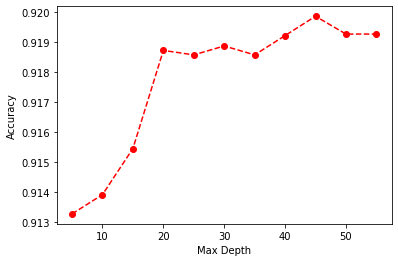

In [104]:
# Plotagem da acurácia para avaliação da distribuição
plt.plot(depths, accuracy, linestyle='--', marker='o', color="red")
plt.xlabel("Max Depth")
plt.ylabel("Accuracy")
plt.show()

In [118]:
# Agora aplicando o nivel com maior acurácia para o modelo
classify = Pipeline(
                [('vect', CountVectorizer(stop_words= list_stops_words,ngram_range=(1,2))), 
                 ('tfidf', TfidfTransformer()),
                 ('clf', DecisionTreeClassifier (max_depth = 45, random_state = 0))])


In [119]:
classify.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 2), preprocessor=None,
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",...
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                        criterion='gini', max_depth=45,
                                        max_features=None, max_le

In [120]:
classify.score(X_test, y_test)

0.9181653192542485

In [121]:
preds = classify.predict(X_test)
print(metrics.classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.98      0.86      0.92      3129
           1       0.87      0.98      0.92      2932

    accuracy                           0.92      6061
   macro avg       0.92      0.92      0.92      6061
weighted avg       0.92      0.92      0.92      6061



# Agora usando o Texto
Agora vamos fazer a aplicação do modelo para analise do corpo do texto

In [123]:
df_train["text"] = df_train['text'].str.lower()
df_train["text"].replace('\n',' ', regex=True, inplace=True)

In [124]:

X_train, X_test, y_train, y_test = train_test_split(df_train["text"], df_train["label"], 
                                                    test_size=0.30, 
                                                    random_state=42)

In [125]:
classify = Pipeline(
                [('vect', CountVectorizer(stop_words= list_stops_words,ngram_range=(1,2))), 
                 ('tfidf', TfidfTransformer()),
                 ('clf', DecisionTreeClassifier(max_depth = 45, 
                             random_state = 0))])

In [126]:
classify.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 2), preprocessor=None,
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",...
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                        criterion='gini', max_depth=45,
                                        max_features=None, max_le

In [127]:
classify.score(X_test, y_test)

0.8765880217785844

In [128]:
preds = classify.predict(X_test)
print(metrics.classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.88      0.89      0.88      3129
           1       0.88      0.87      0.87      2932

    accuracy                           0.88      6061
   macro avg       0.88      0.88      0.88      6061
weighted avg       0.88      0.88      0.88      6061



In [129]:
max_depth_range = list(range(30, 56,5))

accuracy = []
depths = []
for depth in max_depth_range:
        
    classify = Pipeline(
                [('vect', CountVectorizer(stop_words= list_stops_words,ngram_range=(1,2))), 
                 ('tfidf', TfidfTransformer()),
                 ('clf', DecisionTreeClassifier(max_depth = depth, 
                             random_state = 0))])
    scores = cross_val_score(classify, X, y, cv=10)
    score = scores.mean()

    accuracy.append(score)
    depths.append(depth)

In [130]:
pd.DataFrame.from_dict({"max_depth":depths, "accuracy" : accuracy}).sort_values("accuracy",ascending=False)

,max_depth,accuracy
3,45,0.919862
5,55,0.919269
4,50,0.919269
2,40,0.919219
0,30,0.918873
1,35,0.918575


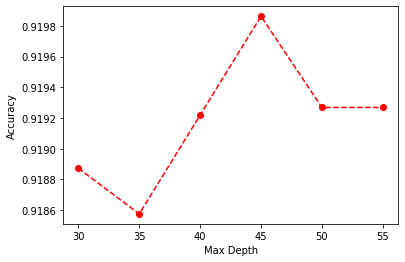

In [131]:
plt.plot(depths, accuracy, linestyle='--', marker='o', color="red")
plt.xlabel("Max Depth")
plt.ylabel("Accuracy")
plt.show()